In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
import seaborn as sns

In [3]:
import os
import sys

In [4]:
# chaging directory

In [5]:
root, *_ = !pwd

In [6]:
if root.endswith('notebooks'):
    os.chdir('../')
    root, *_ = !pwd
    sys.path.append('src/')

In [7]:
os.getcwd()

'/home/med/projects/competitions/mlb-kaggle'

In [8]:
from dotenv import load_dotenv
load_dotenv()

True

In [9]:
RAW_PATH = Path(os.environ['RAW_PATH'])

In [10]:


PROCESSED_PATH = Path(os.environ['ROOT_DIR']) / 'processed'

In [11]:
os.listdir(PROCESSED_PATH)

['target.csv', 'raw_data.csv']

In [12]:
os.listdir(RAW_PATH)

['seasons.csv',
 'teams.csv',
 'example_sample_submission.csv',
 'train.csv',
 'mlb-player-digital-engagement-forecasting.zip',
 'awards.csv',
 'players.csv',
 'example_test.csv',
 'mlb']

In [13]:
df = pd.read_csv(PROCESSED_PATH / 'raw_data.csv', parse_dates=['date'])

/home/med/anaconda3/envs/mlb/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (84) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [14]:
df.head()

,playerId,target1,target2,target3,target4,date,target_avg,battingOrder,gamesPlayedBatting,flyOuts,...,assists,putOuts,errors,chances,rosterDate,teamId,status,numberOfFollowers,awardId,teamFollowers
0,112526,0.055277,5.496109,0.025839,16.176471,2018-01-01,5.438424,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,112526,0.060625,3.252914,0.030486,8.541353,2018-01-02,2.971345,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,112526,0.029341,1.648352,0.032613,10.490112,2018-01-03,3.050104,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,112526,0.014799,2.665894,0.087422,19.091467,2018-01-04,5.464896,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,112526,0.083916,1.161002,0.024759,6.643880,2018-01-05,1.978389,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### time and player data 

In [15]:
_players = pd.read_csv(RAW_PATH / 'players.csv')

In [16]:
_players['playerForTestSetAndFuturePreds'].fillna(False, inplace=True)

In [17]:
player_in_test = _players.query('playerForTestSetAndFuturePreds')['playerId']

### target 

In [18]:
from data.ingest_data import player_stats_features
from data.util import filter_by_id

In [19]:
df = filter_by_id(df, player_in_test)

In [20]:
playerList = df.groupby(['playerId'])['target_avg'].std().sort_values(ascending=False).reset_index()

In [21]:
playerList

,playerId,target_avg
0,547180,18.775985
1,660271,18.055585
2,545361,17.410036
3,605141,17.236386
4,592450,16.850044
...,...,...
1182,593590,0.119988
1183,656458,0.115664
1184,676424,0.094298
1185,641927,0.086976


In [22]:
df = filter_by_id(df, [660271])

df.playerId.nunique()

1

In [23]:
# df.playerId.nunique()

In [24]:
# df = filter_by_id(df, playerList['playerId'].head(10))

# df.playerId.nunique()

### preprocessing 

In [25]:
from typing import List
def forward_fill(df: pd.DataFrame, features: List[str],
                 on='playerId',
                 limit: int =None):
    ffilled_df = df.groupby(on)[features].ffill(limit=limit)
    df.loc[:, features] = ffilled_df
    return df

In [26]:
def gen_hardcoded_features(df: pd.DataFrame):
    # some feature eng for the dates
    df['playerAge'] = (df['date'] - df['DOB']).dt.total_seconds()
    df['playerTSinceDebut'] = (df['date'] - df['mlbDebutDate']).dt.total_seconds()
    df['playerDebutAge'] = (df['mlbDebutDate'] - df['DOB']).dt.total_seconds()
    df['rostersTime'] = (df['date'] - pd.to_datetime(df['rosterDate'])).dt.total_seconds()
    df['rostersTime'] /= 60 * 60 * 24
    # normalize
    df[['playerAge', 'playerTSinceDebut', 'playerDebutAge']] /= 60 * 60 * 24 * 365
    df['AwardWinner'] = df['awardId'].isna().astype(np.float64)
    return df

In [27]:
def fillna(df: pd.DataFrame, fill_value=-1):
    return df.fillna(-1)

In [28]:
from pipeline.core import FunctionTransformer, Pipeline, PdColumnTransformer, PdFeatureUnion
from pipeline.continuous import PdScaleNorm, FilterContinuousFeatures, MedianFillNaN
from pipeline.stats import StatisticGen, LagGen, FeaturesTable
from pipeline.categories import Categorify
from pipeline.season import join_season_info
from pipeline.players import join_players_info

In [29]:
# from sklearn.base import BaseEstimator, TransformerMixin

# class StatsEncoding(BaseEstimator, TransformerMixin):
#     def __init__(self, on: List[str],
#                  stats: List[str] = ['mean'],
#                 dt_col: str = 'date'):
#         self.on = on
#         self.stats = stats
#         self.dt_col = dt_col
    
#     def fit(self, X: pd.DataFrame, y=None):    
#         features = X.columns.drop(self.on + [self.dt_col])
#         daily_features = X.groupby(self.on + [self.dt_col])[features].mean()
        
#         daily_features.reset_index(inplace=True)
#         daily_features.set_index(self.dt_col, inplace=True)
        
        
#         stats_table = (daily_features.groupby(self.on)[features].expanding()
#                       .agg(self.stats))
#         stats_table.columns = ['__'.join(list(f) + ['enc'] + self.on)
#                                for f in stats_table]
        
#         stats_table.reset_index(inplace=True)
#         self.stats_table = stats_table
#         self.max_date = X[self.dt_col].max().to_numpy()

#         return self


#     def transform(self, X: pd.DataFrame):
#         outputX = X.loc[:, self.on + [self.dt_col]].copy()
#         outputX.loc[:, self.dt_col] = np.minimum(outputX[self.dt_col], self.max_date)
        
#         outputX = outputX.merge(self.stats_table,
#                                 how='left',
#                                 on=self.on + [self.dt_col])

#         assert len(outputX) == len(X)
# #         print((X.loc[:, self.on + [self.dt_col]] == outputX.loc[:, self.on + [self.dt_col]]).all())
# #         assert (X.loc[:, self.dt_col] == outputX.loc[:, self.dt_col]).all()  
#         outputX.drop(self.on + [self.dt_col], axis=1, inplace=True)
        
#         return outputX


In [30]:
# transformer for joining data and create base features
fill_forward_tmf = FunctionTransformer(forward_fill, kw_args={'features':['numberOfFollowers',
                                                                        'teamFollowers',
                                                                        'status',
                                                                        'teamId',
                                                                          'rosterDate']})
join_season_tmf = FunctionTransformer(join_season_info,
                                      kw_args={'path_to_season': RAW_PATH / 'seasons.csv',
                                             'date_attr': ['year', 'month']})
join_players_tmf = FunctionTransformer(join_players_info, kw_args={'path_to_players': RAW_PATH / 'players.csv'})
harcoded_feat_tmf = FunctionTransformer(gen_hardcoded_features)

In [31]:
# creating pipeline
join_and_compute_feat_pl = Pipeline([('season', join_season_tmf),
                                     ('players', join_players_tmf),
                                     ('fill_forward', fill_forward_tmf),
                                     ('hardcoded_feat', harcoded_feat_tmf)])

In [32]:
# features to use for target preprocessing
target_cols = ['target1', 'target2', 'target3', 'target4']
index_cols = ['date', 'playerId']
pp_cols = target_cols + index_cols

In [33]:
# categories encoding
categories = ['playerId', 'seasonPart', 'year',
              'primaryPositionName', 'month', 'status', 'teamId', 'awardId']

categories_tmf = PdColumnTransformer([(category, Categorify(add_nan=True), category)
                                       for category in categories])

In [34]:
from sklearn.preprocessing import KBinsDiscretizer
class PdKBinsDiscretizer(KBinsDiscretizer):
    def __init__(self, n_bins: int, strategy: str = 'quantile'):
        super().__init__(n_bins=n_bins, strategy=strategy, encode='ordinal')
        
    def fit(self, X: pd.DataFrame, y=None):
        self._features = list(X.columns)
        return super().fit(X, y)

    def transform(self, X: pd.DataFrame):
        outputX = super().transform(X).astype(np.int64)
        outputX = pd.DataFrame(outputX, columns=self._features)
        return outputX

In [35]:
## merge computed statistics

kbins_tmf = PdKBinsDiscretizer(n_bins=5)
lagger_tmf = PdColumnTransformer([('lags', LagGen(np.arange(1, 30+1)), pp_cols)])

In [36]:
stats_feat_tmf = Pipeline([('lagger_tmf', lagger_tmf),
                           ('fillnan', FunctionTransformer(fillna)),
                            ('discretize', kbins_tmf)  
                          ])

In [37]:
# continuous preprocessing

median_fillnan_columns = ['numberOfFollowers', 'teamFollowers',
                          'playerDebutAge', 'playerAge', 'playerTSinceDebut']
fillnan_median_tmf = MedianFillNaN(median_fillnan_columns)

# get the rest of the continuous features
continuous_feat_tmf = Pipeline([('get_cont_feat', FilterContinuousFeatures()),
                                ('fillnan_median', fillnan_median_tmf),
                                ('fillnan', FunctionTransformer(fillna)),
                                ('normalize', PdScaleNorm())
                               ])

In [38]:
# putting all together
all_features_tmf = PdFeatureUnion([('target_stats', stats_feat_tmf), 
                                   ('cont_feat', continuous_feat_tmf), 
                                  ('cats', categories_tmf),
                                  ])

In [39]:
# main pipeline with all steps 
pipeline = Pipeline([('join_compute', join_and_compute_feat_pl),
                    ('features_gen', all_features_tmf)])

In [40]:
pipeline

Pipeline(steps=[('join_compute',
                 Pipeline(steps=[('season',
                                  FunctionTransformer(func=<function join_season_info at 0x7f2359819d30>,
                                                      kw_args={'date_attr': ['year',
                                                                             'month'],
                                                               'path_to_season': PosixPath('data/raw/seasons.csv')})),
                                 ('players',
                                  FunctionTransformer(func=<function join_players_info at 0x7f2359819e50>,
                                                      kw_args={'path_to_players': PosixPath('data/raw/playe...
                                                                                     ('seasonPart',
                                                                                      Categorify(add_nan=True),
                                                   

In [41]:
from data.split import SplitData

In [42]:
sp = SplitData("2021-03-01", test_days=61)

In [43]:
train_idx = sp.train_idx(df)
valid_idx = sp.valid_idx(df)

In [44]:
%%time
pipeline.fit(sp.filter(df, train_idx))

CPU times: user 133 ms, sys: 229 µs, total: 133 ms
Wall time: 131 ms


Pipeline(steps=[('join_compute',
                 Pipeline(steps=[('season',
                                  FunctionTransformer(func=<function join_season_info at 0x7f2359819d30>,
                                                      kw_args={'date_attr': ['year',
                                                                             'month'],
                                                               'path_to_season': PosixPath('data/raw/seasons.csv')})),
                                 ('players',
                                  FunctionTransformer(func=<function join_players_info at 0x7f2359819e50>,
                                                      kw_args={'path_to_players': PosixPath('data/raw/playe...
                                                                                     ('seasonPart',
                                                                                      Categorify(add_nan=True),
                                                   

In [45]:
%%time
features = pipeline.transform(df)

CPU times: user 104 ms, sys: 11.3 ms, total: 115 ms
Wall time: 112 ms


In [46]:
pd.options.display.max_rows = 100
features.T.head(100)

,0,1,2,3,4,5,6,7,8,9,...,1206,1207,1208,1209,1210,1211,1212,1213,1214,1215
target1__1lag,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,4.0,3.0,4.0,4.0,4.0,4.0,3.0,4.0,3.0
target2__1lag,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,1.0,...,4.0,4.0,2.0,3.0,4.0,4.0,4.0,3.0,4.0,3.0
target3__1lag,0.0,0.0,3.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,...,4.0,4.0,2.0,4.0,4.0,4.0,4.0,3.0,4.0,4.0
target4__1lag,0.0,4.0,3.0,4.0,4.0,3.0,4.0,4.0,4.0,2.0,...,4.0,4.0,3.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0
target1__2lag,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,3.0,4.0
target2__2lag,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,...,4.0,4.0,4.0,2.0,3.0,4.0,4.0,4.0,3.0,4.0
target3__2lag,0.0,0.0,0.0,3.0,4.0,2.0,0.0,0.0,0.0,0.0,...,4.0,4.0,4.0,2.0,4.0,4.0,4.0,4.0,3.0,4.0
target4__2lag,0.0,0.0,4.0,3.0,4.0,4.0,3.0,4.0,4.0,4.0,...,4.0,4.0,4.0,3.0,4.0,3.0,4.0,4.0,4.0,4.0
target1__3lag,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,4.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,3.0
target2__3lag,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,4.0,4.0,4.0,4.0,2.0,3.0,4.0,4.0,4.0,3.0


In [47]:
continuous_feat = features.columns.drop(categories)

In [48]:
df[target_cols] = df[target_cols].astype(np.float32)

In [49]:
train_idx.shape

(1216,)

In [50]:
train_idx.shape

(1216,)

In [51]:
train_data = sp.filter(features, train_idx)

In [52]:
raw_train_df = sp.filter(df, train_idx)

In [53]:
valid_data = sp.filter(features, valid_idx)
raw_valid_df = sp.filter(df, valid_idx)

In [54]:
train_data.shape, raw_valid_df.shape

((1155, 211), (61, 86))

In [55]:
valid_data.shape, raw_train_df.shape

((61, 211), (1155, 86))

In [56]:
train_data[target_cols + ['date']] = raw_train_df[target_cols + ['date']]
valid_data[target_cols + ['date']] = raw_valid_df[target_cols + ['date']]

### modeling 

In [57]:
time_features = ['battingOrder', 'gamesPlayedBatting', 'flyOuts', 'groundOuts',
       'runsScored', 'doubles', 'triples', 'homeRuns', 'strikeOuts',
       'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch', 'atBats',
       'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances']

In [58]:
static_features = list(features.columns.drop(categories + time_features))

In [59]:
static_features

['target1__1lag',
 'target2__1lag',
 'target3__1lag',
 'target4__1lag',
 'target1__2lag',
 'target2__2lag',
 'target3__2lag',
 'target4__2lag',
 'target1__3lag',
 'target2__3lag',
 'target3__3lag',
 'target4__3lag',
 'target1__4lag',
 'target2__4lag',
 'target3__4lag',
 'target4__4lag',
 'target1__5lag',
 'target2__5lag',
 'target3__5lag',
 'target4__5lag',
 'target1__6lag',
 'target2__6lag',
 'target3__6lag',
 'target4__6lag',
 'target1__7lag',
 'target2__7lag',
 'target3__7lag',
 'target4__7lag',
 'target1__8lag',
 'target2__8lag',
 'target3__8lag',
 'target4__8lag',
 'target1__9lag',
 'target2__9lag',
 'target3__9lag',
 'target4__9lag',
 'target1__10lag',
 'target2__10lag',
 'target3__10lag',
 'target4__10lag',
 'target1__11lag',
 'target2__11lag',
 'target3__11lag',
 'target4__11lag',
 'target1__12lag',
 'target2__12lag',
 'target3__12lag',
 'target4__12lag',
 'target1__13lag',
 'target2__13lag',
 'target3__13lag',
 'target4__13lag',
 'target1__14lag',
 'target2__14lag',
 'target3_

In [60]:
# from omegaconf import OmegaConf
# hp = {'bptt': 7,
#       'epochs': 10,
#       'batch_size': 2048,
#       'max_emb_sz': 20,
#       'hidden_dim': 32,
#       'encoder_dim': 128,
#       'emb_dropout': 0.2,
#       'dropout': 0.2,
#       'lr': 0.001,
#       'wd': 3e-5}

# lstm_config = {'hp': hp,
#                     'seed': 2021,
#          'static_features': static_features,
#           'categories': categories,
#           'time_features': time_features,
#           'target_cols': target_cols}
# lstm_config = OmegaConf.create(lstm_config) 

In [61]:
from train.lgbm import run_lgbm

In [62]:
static_features

['target1__1lag',
 'target2__1lag',
 'target3__1lag',
 'target4__1lag',
 'target1__2lag',
 'target2__2lag',
 'target3__2lag',
 'target4__2lag',
 'target1__3lag',
 'target2__3lag',
 'target3__3lag',
 'target4__3lag',
 'target1__4lag',
 'target2__4lag',
 'target3__4lag',
 'target4__4lag',
 'target1__5lag',
 'target2__5lag',
 'target3__5lag',
 'target4__5lag',
 'target1__6lag',
 'target2__6lag',
 'target3__6lag',
 'target4__6lag',
 'target1__7lag',
 'target2__7lag',
 'target3__7lag',
 'target4__7lag',
 'target1__8lag',
 'target2__8lag',
 'target3__8lag',
 'target4__8lag',
 'target1__9lag',
 'target2__9lag',
 'target3__9lag',
 'target4__9lag',
 'target1__10lag',
 'target2__10lag',
 'target3__10lag',
 'target4__10lag',
 'target1__11lag',
 'target2__11lag',
 'target3__11lag',
 'target4__11lag',
 'target1__12lag',
 'target2__12lag',
 'target3__12lag',
 'target4__12lag',
 'target1__13lag',
 'target2__13lag',
 'target3__13lag',
 'target4__13lag',
 'target1__14lag',
 'target2__14lag',
 'target3_

In [63]:
from omegaconf import OmegaConf

parameters = {
#  'objective':'mae',
 'reg_alpha': 0.1,
 'reg_lambda': 0.1, 
 'n_estimators': 100000,
 'learning_rate': 0.1,
 'random_state': 42,
}
config = {'hp': parameters,
          'features': categories + static_features + time_features,
          'categories': categories,
          'target_cols': target_cols}
config = OmegaConf.create(config)

In [64]:
output = run_lgbm(config, train_data, valid_data)

target1
Training until validation scores don't improve for 100 rounds


/home/med/anaconda3/envs/mlb/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/med/anaconda3/envs/mlb/lib/python3.8/site-packages/lightgbm/basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['awardId', 'month', 'playerId', 'primaryPositionName', 'seasonPart', 'status', 'teamId', 'year']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/home/med/anaconda3/envs/mlb/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/med/anaconda3/envs/mlb/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[100]	valid_0's l2: 975.58
Early stopping, best iteration is:
[21]	valid_0's l2: 903.019
target2
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 843.213
Early stopping, best iteration is:
[41]	valid_0's l2: 827.755
target3
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 1214.31
Early stopping, best iteration is:
[61]	valid_0's l2: 1193.72
target4
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 878.532
Early stopping, best iteration is:
[38]	valid_0's l2: 859.387


In [65]:
from evaluate.metrics import compute_metrics

with best 500 ids 
one day lag

{'mae_mean': 15.404842,
 'mae_1': 15.112363,
 'mae_2': 12.518346,
 'mae_3': 15.941521,
 'mae_4': 18.04714}
 
{'mae_mean': 16.107979,
 'mae_1': 14.4299965,
 'mae_2': 13.712786,
 'mae_3': 17.216927,
 'mae_4': 19.072205}
 
lag 60 day 150 stats mean median std
raw_valid_df

{'mae_mean': 16.526415,
 'mae_1': 15.134252,
 'mae_2': 15.736391,
 'mae_3': 16.731949,
 'mae_4': 18.503065}
 
{'mae_mean': 16.243195,
 'mae_1': 14.64544,
 'mae_2': 15.223519,
 'mae_3': 16.67205,
 'mae_4': 18.43177}
 
 
with best 500 ids 
one day lag 
{'mae_mean': 2.4375365,
 'mae_1': 2.2795138,
 'mae_2': 3.1164076,
 'mae_3': 1.6708878,
 'mae_4': 2.6833365}
 
{'mae_mean': 3.2938020082107333,
 'mae_1': 2.5740078375938165,
 'mae_2': 5.631358953836824,
 'mae_3': 1.837284798457624,
 'mae_4': 3.1325564429546677}
 
lag 60 day 150 stats mean median std

{'mae_mean': 2.8213322,
 'mae_1': 2.4738746,
 'mae_2': 3.9536836,
 'mae_3': 1.8413752,
 'mae_4': 3.0163958}
 
{'mae_mean': 2.8054446768310446,
 'mae_1': 2.4669433853402922,
 'mae_2': 3.901420425393473,
 'mae_3': 1.8396196560640896,
 'mae_4': 3.0137952405263246}
 
 con toda la data
 
 {'mae_mean': 1.5619345,
 'mae_1': 1.2107118,
 'mae_2': 2.4501314,
 'mae_3': 0.95569867,
 'mae_4': 1.6311963}
 
 
 {'mae_mean': 1.5390999144452775,
 'mae_1': 1.210369386168515,
 'mae_2': 2.3818660584590656,
 'mae_3': 0.9496059085908733,
 'mae_4': 1.6145583045626561}
 

In [66]:
from train.core import predict_recursive, Ensemble

In [67]:
ensemble = Ensemble([output], pipeline)

In [68]:
%%time
raw_train_fr = raw_train_df.query("date >= '2020-07-01'").reset_index(drop=True)
raw_train_fr = raw_train_fr[df.columns]

recursive_prediction = []
for date, val_date_df in raw_valid_df.groupby('date'):
    val_date_df = val_date_df[df.columns].reset_index(drop=True)
    _recurive_pred, raw_train_fr = predict_recursive(val_date_df,
                                                     raw_train_fr,
                                                     ensemble,
                                                     n_days=30,
                                                     target_cols=target_cols)
    recursive_prediction.append(_recurive_pred)

recursive_prediction = pd.concat(recursive_prediction, ignore_index=True)
recursive_prediction.sort_values(['playerId', 'date'], inplace=True)
recursive_prediction.reset_index(drop=True, inplace=True)
recursive_prediction.rename(columns={f: f.replace('target', 'yhat')
                                     for f in target_cols}, inplace=True)
recursive_prediction[target_cols] = raw_valid_df[target_cols].to_numpy()

    target1    target2   target3   target4       date  playerId
0  8.653169  19.822428  9.125363  8.268617 2021-03-01    660271
     target1   target2   target3   target4       date  playerId
0  11.886603  28.24553  5.198848  9.754782 2021-03-02    660271
    target1    target2    target3    target4       date  playerId
0  9.921635  29.775351  17.348295  10.036719 2021-03-03    660271
     target1    target2   target3   target4       date  playerId
0  16.735137  27.792399  29.41166  6.993824 2021-03-04    660271
     target1    target2    target3   target4       date  playerId
0  15.558041  35.659969  25.879314  7.476051 2021-03-05    660271
     target1    target2    target3    target4       date  playerId
0  12.012372  30.748692  16.246186  10.236375 2021-03-06    660271
    target1    target2    target3    target4       date  playerId
0  5.992026  29.166171  13.245172  12.776819 2021-03-07    660271
    target1    target2    target3    target4       date  playerId
0  9.747285  29.74

no propating forward
{'mae_mean': 1.6181669660843265,
 'mae_1': 1.2681040951665854,
 'mae_2': 2.542929024032986,
 'mae_3': 0.9624048148661487,
 'mae_4': 1.699229930271586}

In [69]:
valid_test_prediction = pd.DataFrame(output.prediction, columns=['yhat1', 'yhat2', 'yhat3', 'yhat4'])

valid_test_prediction[pp_cols] = raw_valid_df[pp_cols]

In [70]:
is_test_pred = valid_test_prediction['date'] >= '2021-04-01'

valid_prediction, test_prediction = (valid_test_prediction.loc[~is_test_pred, :],
                                     valid_test_prediction.loc[is_test_pred, :])

In [71]:
compute_metrics(valid_test_prediction)

{'mae_mean': 21.383084917409917,
 'mae_1': 21.006242058479707,
 'mae_2': 21.735568428463097,
 'mae_3': 22.707449881372753,
 'mae_4': 20.083079301324126}

In [72]:
compute_metrics(valid_prediction)

{'mae_mean': 21.1287492282479,
 'mae_1': 23.792223406467357,
 'mae_2': 24.249161647061243,
 'mae_3': 22.40096766094474,
 'mae_4': 14.072644198518262}

In [73]:
compute_metrics(test_prediction)

{'mae_mean': 21.645898462877334,
 'mae_1': 18.12739466555913,
 'mae_2': 19.138188769245005,
 'mae_3': 23.024148175815032,
 'mae_4': 26.293862240890167}

In [74]:
valid_rc_prediction, test_rc_prediction = (recursive_prediction.loc[~is_test_pred, :],
                                           recursive_prediction.loc[is_test_pred, :])

In [75]:
compute_metrics(valid_rc_prediction)

{'mae_mean': 23.90198083921349,
 'mae_1': 25.04379237785633,
 'mae_2': 28.167945348253358,
 'mae_3': 23.961176965171386,
 'mae_4': 18.43500866557288}

In [76]:
compute_metrics(test_rc_prediction)

{'mae_mean': 23.329290820012773,
 'mae_1': 17.727249921040933,
 'mae_2': 23.689324256251812,
 'mae_3': 26.05161489107922,
 'mae_4': 25.848974211679113}

In [77]:
compute_metrics(recursive_prediction)

{'mae_mean': 23.620330010098378,
 'mae_1': 21.445492808930723,
 'mae_2': 25.965344811203412,
 'mae_3': 24.989261191027698,
 'mae_4': 22.081221229231684}

{'mae_mean': 8.744398122453422,
 'mae_1': 8.91478917325309,
 'mae_2': 8.77152911391691,
 'mae_3': 7.268066076937021,
 'mae_4': 10.023208125706667}


{'mae_mean': 7.778629376660697,
 'mae_1': 7.032324510699994,
 'mae_2': 9.003801645329068,
 'mae_3': 6.445435023328167,
 'mae_4': 8.632956327285559}

{'mae_mean': 8.269542728999648,
 'mae_1': 7.989123162641596,
 'mae_2': 8.885384394035018,
 'mae_3': 6.863603225531401,
 'mae_4': 9.34006013379057}

In [78]:
def plot_pred(df, playerId, index=1):
    pdf = df.query(f'playerId == {playerId}')
    
    f, ax = plt.subplots(1, 1, figsize=(20, 5))
    
    tname = f'target{index}'
    yhat_name = f'yhat{index}'
    
    ax.plot('date', tname, '-o', data=pdf, label=tname)
    ax.plot('date', yhat_name, '-o', data=pdf, label=tname)
    
    ax.legend()
    

In [79]:
def feature_importance(features, model):
    fi = pd.DataFrame({'feature': features, 'importance': model.feature_importances_})
    fi.sort_values(by='importance', ascending=False, inplace=True)
    return fi

def compute_fi(features, models):
    fi = [feature_importance(features, _model).assign(target=f'target{target}')
      for target, _model in enumerate(models)]
    fi = pd.concat(fi)
    fi = fi.pivot('feature', 'target', 'importance')
    fi = fi * 100 / fi.sum()
    fi['mean'] = fi.mean(axis=1)
    fi.sort_values(by='mean', ascending=False, inplace=True)
    return fi

In [80]:
fi = compute_fi(config.features, output.model)

In [81]:
fi.head(100)

target,target0,target1,target2,target3,mean
feature,,,,,
playerAge,5.246423,3.821138,5.136612,7.456140,5.415078
teamFollowers,5.087440,2.439024,2.841530,3.245614,3.403402
target2__1lag,3.656598,5.528455,1.748634,1.228070,3.040439
target4__1lag,0.476948,2.845528,1.693989,6.754386,2.942713
target3__1lag,2.543720,1.219512,5.956284,0.964912,2.671107
target1__1lag,7.631161,0.569106,1.475410,0.964912,2.660147
month,0.635930,2.276423,0.874317,2.368421,1.538773
target3__7lag,1.748808,1.300813,0.819672,1.228070,1.274341
target3__2lag,1.430843,0.650407,1.967213,0.789474,1.209484


In [82]:
(recursive_prediction.groupby('playerId')
 .apply(lambda x: pd.Series(compute_metrics(x)))
 .sort_values(by='mae_mean', ascending=False)).head(10)

,mae_mean,mae_1,mae_2,mae_3,mae_4
playerId,,,,,
660271,23.62033,21.445493,25.965345,24.989261,22.081221


22.287758	23.63591	24.933866	23.164949	17.416305

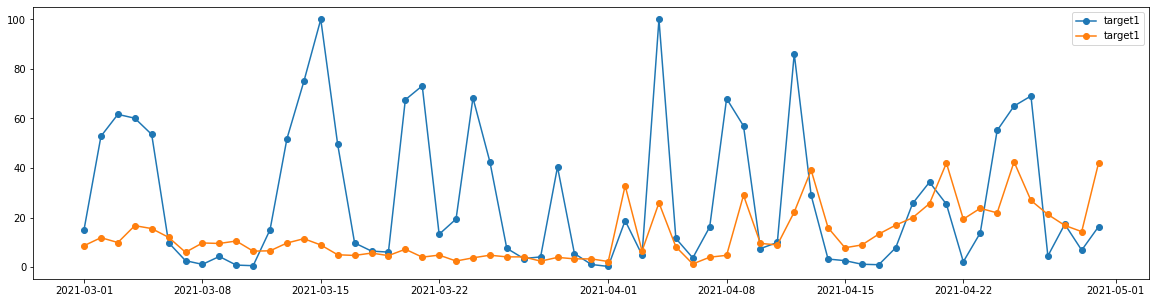

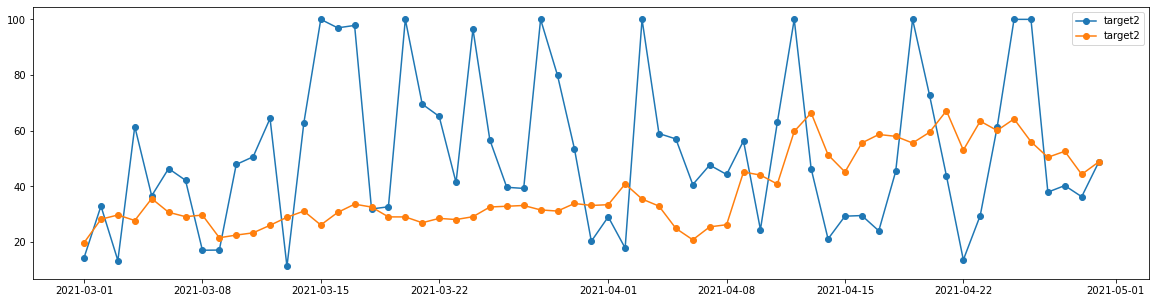

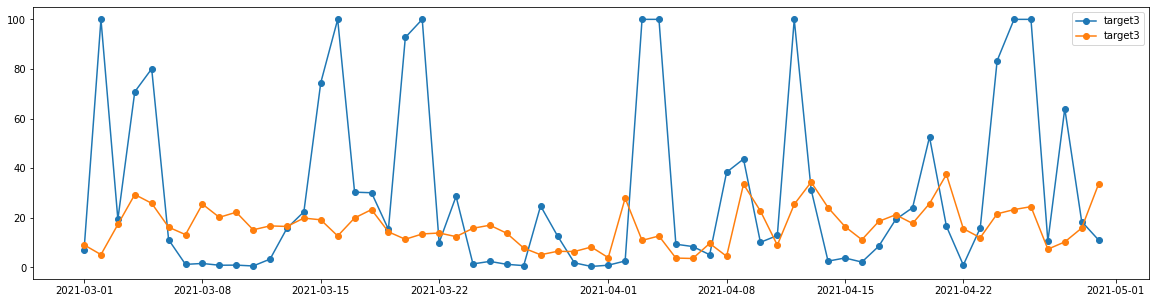

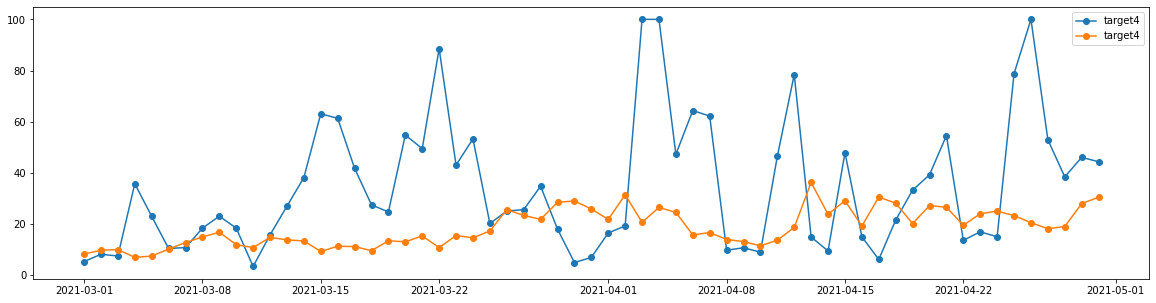

In [83]:
for index in range(1, 5):
    plot_pred(recursive_prediction, playerId=660271, index=index)

In [84]:
# import gc
# gc.collect()